In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from datetime import datetime
import matplotlib.cm as cm

# setting things up:

In [2]:
path = Path.cwd()
forcing_path = path / "Forcing"
observations_path = path / "Observations"
output_path = path / "Output"
paths = forcing_path, output_path, observations_path
figure_path = path / "Figures"

In [3]:
units= {"Imax":"mm",
        "Ce": "-",
        "Sumax": "mm",
        "Beta": "-",
        "Pmax": "mm",
        "Tlag": "d",
        "Kf": "-",
        "Ks": "-",
        "FM":'mm/d/degC',
        "Si": "mm",
        "Su": "mm",
        "Sf": "mm",
        "Ss": "mm",
        "Sp": "mm",
        "Ei_dt": "mm/d",
        "Ea_dt": "mm/d",
        "Qs_dt": "mm/d",
        "Qf_dt": "mm/d",
        "Q_tot_dt": "mm/d",
        "Q": "mm/d"}

p_names = ["$I_{max}$",  "$C_e$",  "$Su_{max}$", "β",  "$P_{max}$",  "$T_{lag}$",   "$K_f$",   "$K_s$", "FM"]
S_names = ["Interception storage", "Unsaturated Rootzone Storage", "Fastflow storage", "Groundwater storage", "Snowpack storage"]
names = p_names + S_names
param_names = ["Imax","Ce",  "Sumax", "Beta",  "Pmax",  "Tlag",   "Kf",   "Ks", "FM"]
stor_names = ["Si", "Su", "Sf", "Ss", "Sp"]

var_names =  {x: names[i] for i, x in enumerate(param_names + stor_names)}

In [4]:
def calc_NSE(Qo, Qm):
    QoAv  = np.mean(Qo)
    ErrUp = np.sum((Qo - Qm)**2)
    ErrDo = np.sum((Qo - QoAv)**2)
    return 1 - (ErrUp / ErrDo)
    
def calc_log_NSE(Qo, Qm):
    Qo[Qo == 0] = 1e-6
    QoAv  = np.mean(Qo)
    ErrUp = np.sum((np.log(Qo) - np.log(Qm))**2)
    ErrDo = np.sum((np.log(Qo) - np.log(QoAv))**2)
    return 1 - (ErrUp / ErrDo)

In [5]:
def plot_hydrograph(ds_combined, ax):
    NSE_mean = calc_NSE(ds_combined["Q_obs"].values, ds_combined["Q"].sel(summary_stat="mean").values)
    NSE_mean_log = calc_log_NSE(ds_combined["Q_obs"].values, ds_combined["Q"].sel(summary_stat="mean").values)
    
    ds_combined["Q_obs"].plot(ax=ax,lw=0,marker="*",ms=2.0,zorder=0,label="Observations",color='k')
    
    ds_combined["Q"].sel(summary_stat="mean").plot(ax=ax, color="C1",lw=0.5,label=f"mean NSE: {NSE_mean:.2f}\n   Log NSE: {NSE_mean_log:.2f}",zorder=-1)
    
    ax.fill_between(ds_combined.time, 
                             ds_combined["Q"].sel(summary_stat="min").values,
                             ds_combined["Q"].sel(summary_stat="max").values,color="C0", alpha=0.35,zorder=-10,label="bounds")
    n_particles = ds_combined.attrs['n_particles']
    ax.set_ylabel("Q [mm]")
    ax.set_title(f"Run ensemble of {n_particles} particles");
    return ax

In [6]:
def plot_variable(ds_combined, variable, axs):    
    axs[0] = plot_hydrograph(ds_combined, axs[0])
    n_particles = ds_combined.attrs['n_particles']
    
    for i, var in enumerate(variable):
        for j in range(n_particles):
            axs[i+1].fill_between(ds_combined.time, 
                             ds_combined[var].sel(summary_stat="min").values,
                             ds_combined[var].sel(summary_stat="max").values, color=f"C{i}",alpha=0.5)
            axs[i+1].set_title(var_names[var])
            axs[i+1].set_ylabel(f'{var} [{units[var]}]')
    return axs

# Loading files

In [7]:
files = list((output_path).glob('*.nc'))

In [8]:
dict_files = {}
for file in files:
    sig = file.name.split('_')[1]
    sig = sig[sig.find("-")+1:]
    sig = f"{float(sig):.0e}"
    w = file.name.split('_')[4].split('-')[1]
    dict_files.update(
                       {f"{file.name.split('_')[0]}_{w}_{sig}" : file}
                        )
sorted_iter = sorted(dict_files.keys())[::-1]

In [9]:
lst_ds = []
for key in sorted_iter:
    ds = xr.open_dataset(dict_files[key])
    lst_ds.append(ds)

In [10]:
df = pd.DataFrame(columns=["NSE_mean","NSE_mean_log", "sigma_p_Sf","sigma_w"])
for index, ds_combined in enumerate(lst_ds):
    uid = sorted_iter[index]
    df.loc[uid, 'NSE_mean'] = calc_NSE(ds_combined["Q_obs"].values, ds_combined["Q"].sel(summary_stat="mean").values)
    df.loc[uid, 'NSE_mean_log'] = calc_log_NSE(ds_combined["Q_obs"].values, ds_combined["Q"].sel(summary_stat="mean").values)
    df.loc[uid, 'sigma_p_Sf'] = ds_combined.attrs["sigma_p_Sf"]
    df.loc[uid, 'sigma_w'] = ds_combined.attrs["sigma_w"]

df = df[df['NSE_mean']>0]

In [11]:
df = df.sort_values('NSE_mean_log',ascending=False)
df.head(8)

,NSE_mean,NSE_mean_log,sigma_p_Sf,sigma_w
01073000_2_1e-02,0.658984,0.725214,0.01,2
01073000_2_1e-07,0.667007,0.708946,0.0,2
01047000_5_1e-02,0.493144,0.644649,0.01,5
01118300_2_1e-07,0.407931,0.627564,0.0,2
01078000_2_1e-07,0.560849,0.618571,0.0,2
01118300_9_1e-05,0.200759,0.605247,0.00001,9
01118300_9_1e-03,0.236821,0.604847,0.001,9
01118300_9_1e-07,0.18243,0.59967,0.0,9


In [12]:
df.sort_values('NSE_mean_log',ascending=True).head(3)

,NSE_mean,NSE_mean_log,sigma_p_Sf,sigma_w
01137500_7_1e-02,0.012587,-0.96799,0.01,7
01137500_7_1e-07,0.021887,-0.91978,0.0,7
01137500_7_1e-03,0.063859,-0.798086,0.001,7


In [13]:
df['HRU_id'] = df.apply(lambda x: x.name,axis=1)

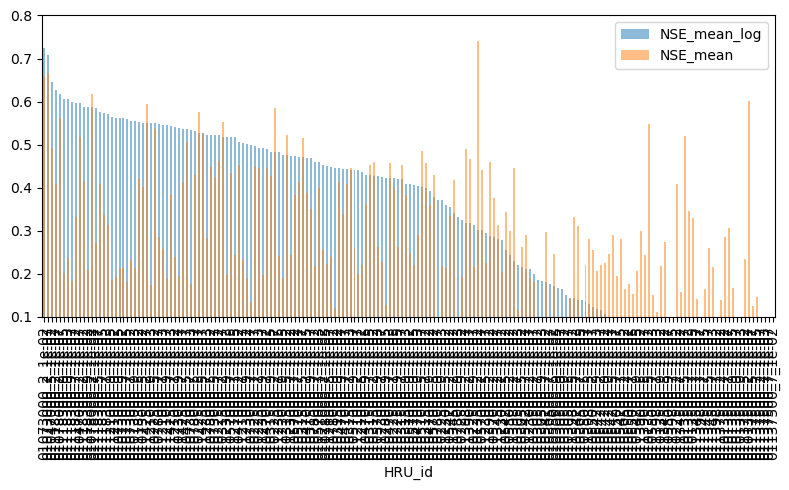

In [14]:
fig, ax = plt.subplots(1,1, sharey=True,figsize=(8,5))
ax=[ax]
df.plot.bar('HRU_id','NSE_mean_log',ax=ax[0],color="C0",alpha=0.5)#lw=0, marker='.',ax=ax[0])
df.plot.bar('HRU_id','NSE_mean',ax=ax[0],color="C1",alpha=0.5) #lw=0, marker='.',ax=ax[0])


# df.plot('sigma_p_Sf','NSE_mean',lw=0, marker='.',ax=ax[1])
# df.plot('sigma_p_Sf','NSE_mean_log',lw=0, marker='.',ax=ax[1])
# ax[0].invert_xaxis()
ax[0].set_ylim(0.1,0.8)
# ax[1].set_xscale('log')
fig.tight_layout()
# ax[0].set_xlim((0,5))
# fig.savefig(figure_path / f'vary_catchments_nse_s.png', bbox_inches="tight",dpi=400)

In [15]:
df[df['NSE_mean_log'] > 0]['NSE_mean_log'].mean()

0.3949527731603434

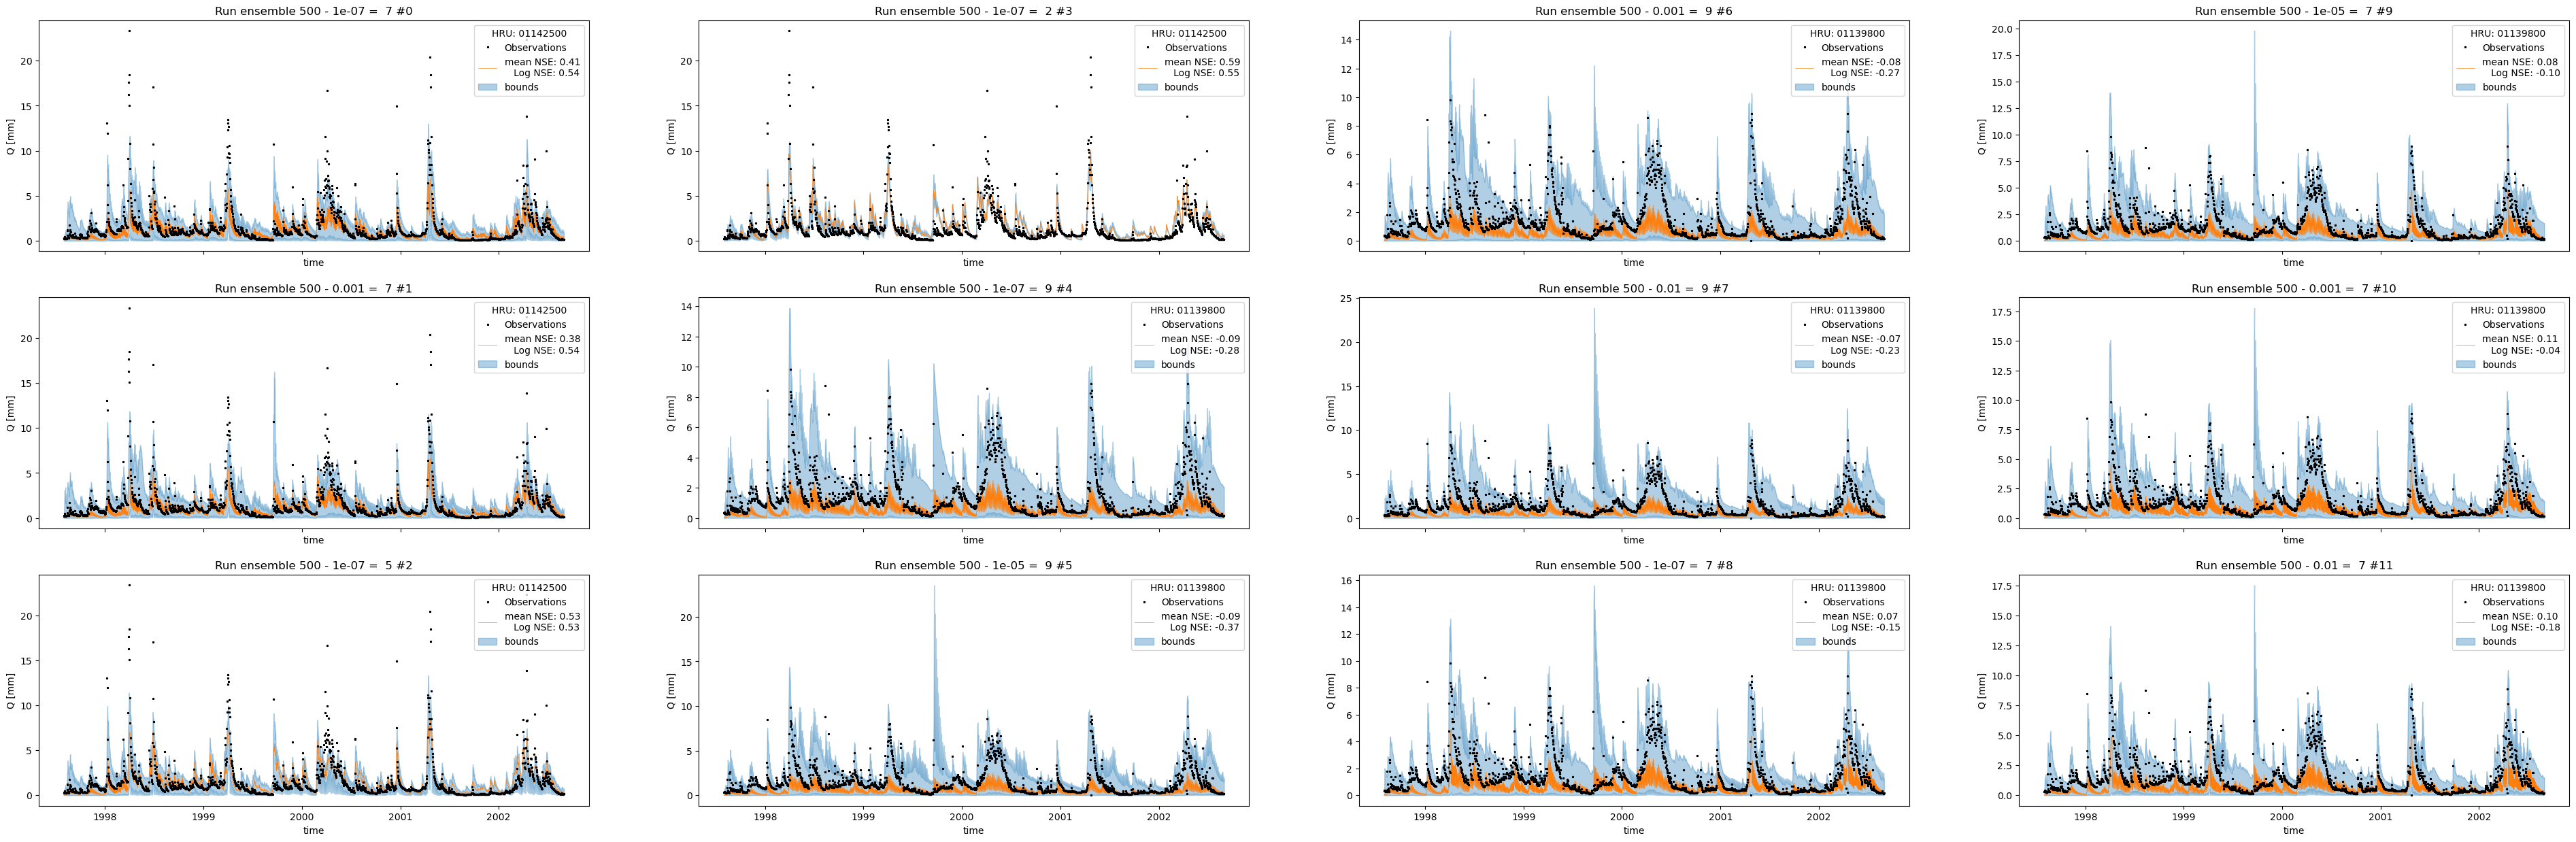

In [16]:
y1, x1   = 3 , 4
fig, axs_2d = plt.subplots(y1,x1,figsize=(12*x1,5*y1), sharex=True)
j = 0
k = 0
for i in range(0,x1*y1):
    if k >= y1: 
        j += 1
        k = 0
    ax = axs_2d[k, j]
    k += 1

    if i >= len(lst_ds):
        ax.axis('off')
    else:
        ds_combined = lst_ds[i]
        ax = plot_hydrograph(ds_combined, ax)
        ax.set_title(f'Run ensemble {ds_combined.attrs["n_particles"]} - {ds_combined.attrs["sigma_p_Sf"]} =  {ds_combined.attrs["sigma_w"]} #{i}')
        # if k == 1:
        ax.legend(title=f"HRU: {ds_combined.attrs['HRU_id']}")
        # else:
            # ax.legend()

# fig.savefig(figure_path / f'vary_catchments.png', bbox_inches="tight",dpi=400)

In [17]:
param_arr = np.zeros((len(lst_ds),2,len(param_names)))
stor_arr = np.zeros((len(lst_ds),2,len(stor_names)))
         
for index, ds_combined in enumerate(lst_ds):
    param_arr[index,0] = ds_combined.attrs['p_min_initial'] 
    param_arr[index,1] = ds_combined.attrs['p_max_initial']
    stor_arr[index,0] = ds_combined.attrs['s_min_initial'] 
    stor_arr[index,1] = ds_combined.attrs['s_max_initial']

In [18]:
param_names_no_su = param_names[:2] + param_names[3:]
param_names_no_su

['Imax', 'Ce', 'Beta', 'Pmax', 'Tlag', 'Kf', 'Ks', 'FM']

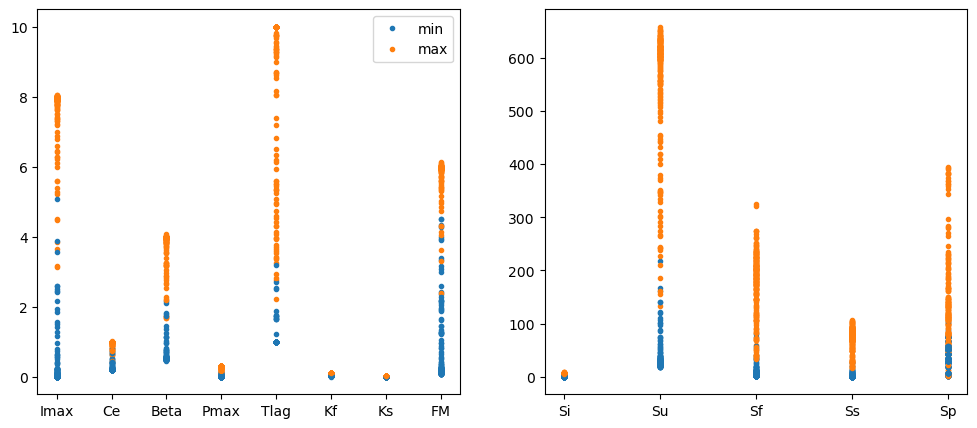

In [19]:
fig, ax = plt.subplots(1,2,figsize=(12,5))
for arr in param_arr:
    arr_no_su_0 = list(arr[0][:2]) + list(arr[0][3:])
    ax[0].plot(param_names_no_su, arr_no_su_0, color="C0",label="min",marker='.',lw=0)
    arr_no_su_1 = list(arr[1][:2]) + list(arr[1][3:])
    ax[0].plot(param_names_no_su, arr_no_su_1, color="C1",label="max",marker='.',lw=0)

handels, labels = ax[0].get_legend_handles_labels()
ax[0].legend(handels[:2], labels[:2])
for arr in stor_arr:
    ax[1].plot(stor_names, arr[0], color="C0",marker='.',lw=0)
    ax[1].plot(stor_names, arr[1], color="C1",marker='.',lw=0)